100%|██████████| 49/49 [00:00<00:00, 71.15it/s]


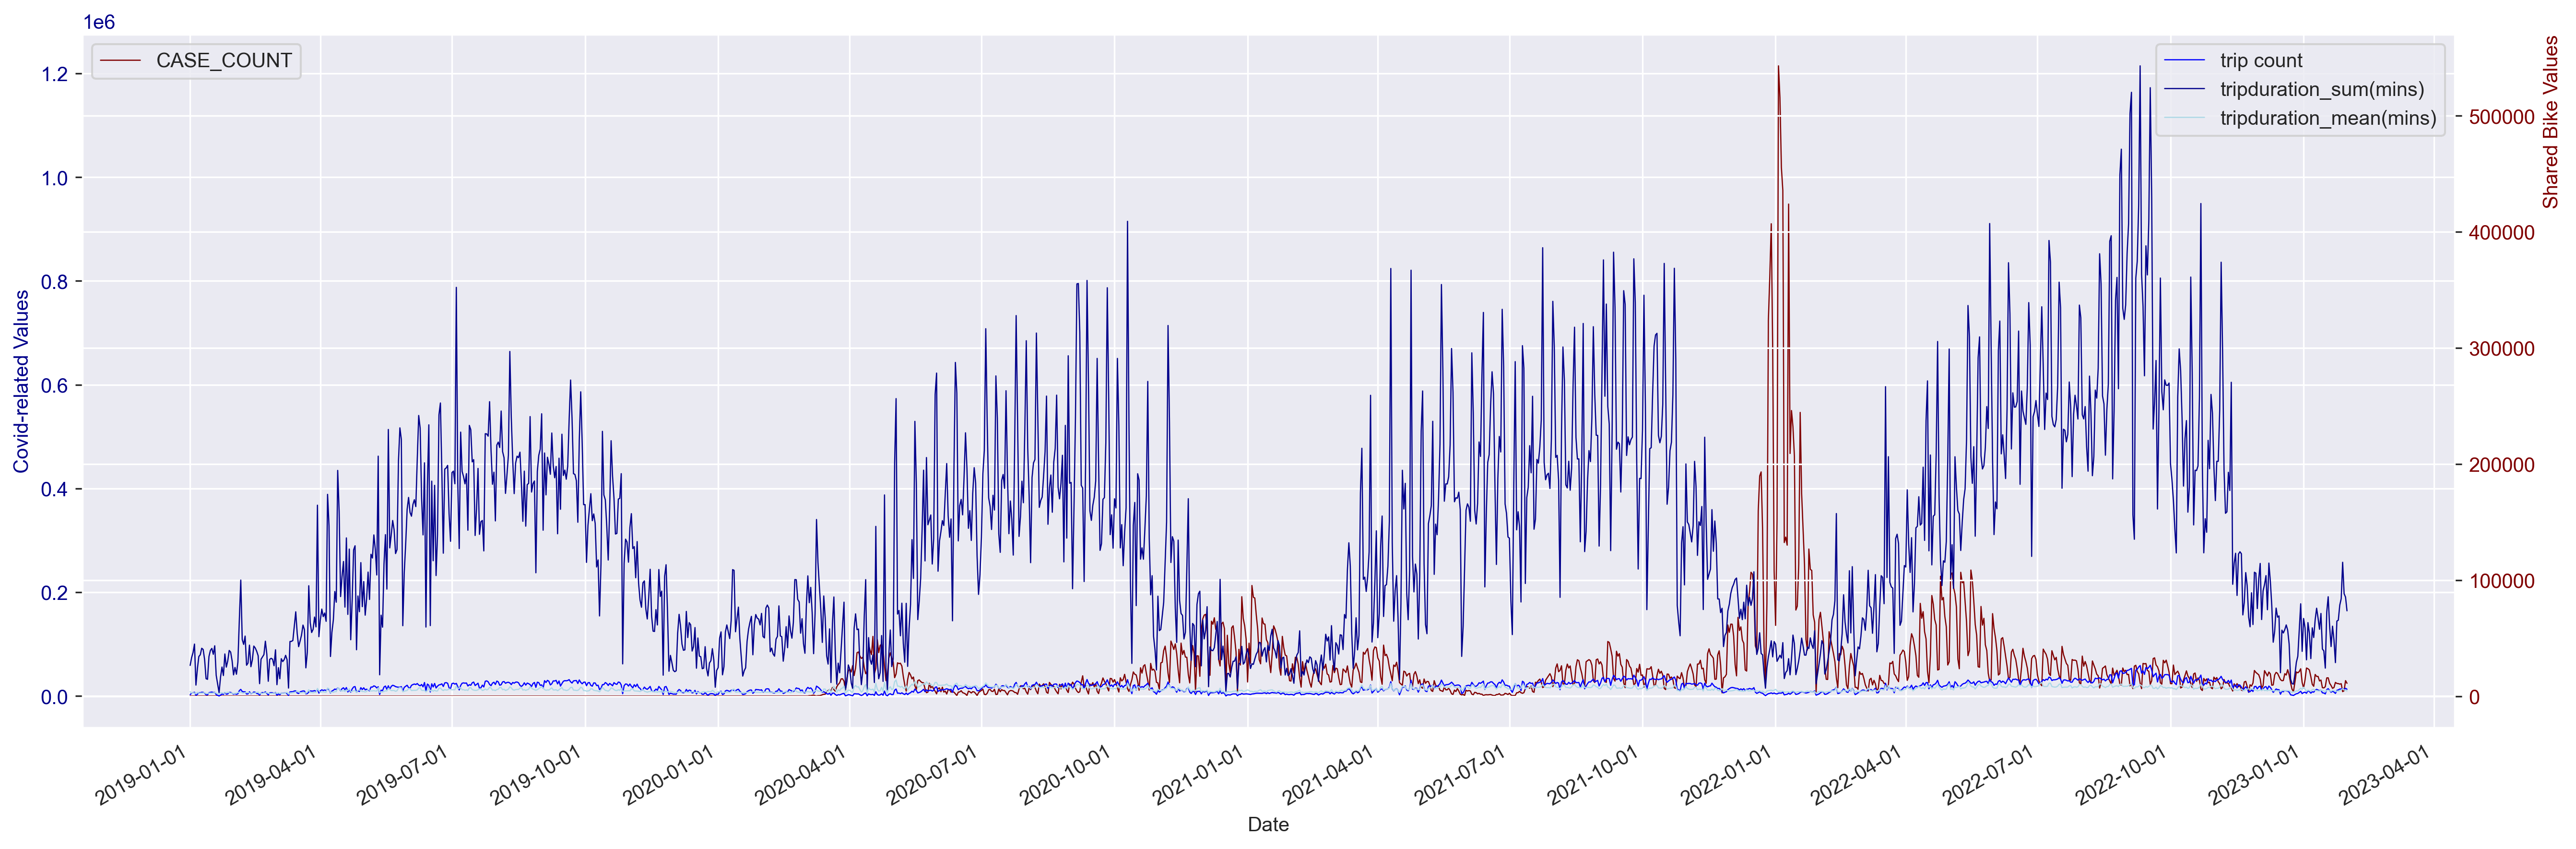

  0%|          | 0/3 [00:00<?, ?it/s]/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index

In [3]:
import io
import itertools
from sklearn.metrics import mean_squared_error
from data_clean import merge_csv
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from tqdm import tqdm
import subprocess
import sys
from scipy import stats

# change the output path
sys.stdout = open('output/temporal/BST_Running info of ESDA.txt', 'w')

# temporal analysis part
df = merge_csv('data/SharedBike/bst')
# print(bike.iloc[0])
# print(bike.head())
# print(bike.describe())
if 'BX_CASE_COUNT' in df.columns:
    agg_func = {'start station id': 'count', 'trip count': 'sum', 'tripduration_sum(mins)': 'sum',
                'tripduration_mean(mins)': 'sum',
                'CASE_COUNT': 'sum', 'HOSPITALIZED_COUNT': 'sum', 'DEATH_COUNT': 'sum',
                'BX_CASE_COUNT': 'sum', 'BX_DEATH_COUNT': 'sum', 'BK_CASE_COUNT': 'sum', 'BK_DEATH_COUNT': 'sum',
                'MN_CASE_COUNT': 'sum', 'MN_DEATH_COUNT': 'sum', 'QN_CASE_COUNT': 'sum', 'QN_DEATH_COUNT': 'sum',
                'SI_CASE_COUNT': 'sum', 'SI_DEATH_COUNT': 'sum'}
else:
    agg_func = {'start station id': 'count', 'trip count': 'sum', 'tripduration_sum(mins)': 'sum',
                'tripduration_mean(mins)': 'sum',
                'CASE_COUNT': 'sum'}

df_temporal = df.groupby('date').agg(agg_func)
df_temporal.index = pd.to_datetime(df_temporal.index)
print('\n{:=^60s}'.format('df_temporal'))
print(df_temporal.shape)
print(df_temporal.head())
print(df_temporal.iloc[0])
print(df_temporal.describe())
print(df_temporal.columns)

# visualize the temporal data
# sns.lineplot(data=df_temporal, x='date', y='tripduration_sum(mins)')
# cmap_r = cm.get_cmap('Reds_r', 3)
# cmap_b = cm.get_cmap('Blues_r', 3)
# cmap_o = cm.get_cmap('ocean', len(df_temporal.columns))
cmap_r = ['maroon', 'brown', 'crimson']
cmap_b = ['blue', 'darkblue', 'lightblue']
fig, ax1 = plt.subplots(figsize=(18, 6), dpi=300)
ax2 = ax1.twinx()
count_r = 0
count_b = 0
for i in range(len(df_temporal.columns)):
    if df_temporal.columns[i] in ['BX_CASE_COUNT', 'BX_DEATH_COUNT', 'BK_CASE_COUNT',
                                  'BK_DEATH_COUNT', 'MN_CASE_COUNT', 'MN_DEATH_COUNT', 'QN_CASE_COUNT',
                                  'QN_DEATH_COUNT', 'SI_CASE_COUNT', 'SI_DEATH_COUNT']:
        ax1.plot(df_temporal.index, df_temporal.iloc[:, i], color='lightgrey', label=df_temporal.columns[i],
                 linewidth=0.6)
    elif df_temporal.columns[i] in ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT']:

        ax1.plot(df_temporal.index, df_temporal.iloc[:, i], color=cmap_r[count_r], label=df_temporal.columns[i],
                 linewidth=0.6)
        count_r += 1

    elif df_temporal.columns[i] in ['tripduration_sum(mins)', 'tripduration_mean(mins)', 'trip count']:
        ax2.plot(df_temporal.index, df_temporal.iloc[:, i], color=cmap_b[count_b], label=df_temporal.columns[i],
                 linewidth=0.6)
        count_b += 1

ax1.set_xlabel('Date')
ax1.set_ylabel('Covid-related Values', color='darkblue')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2.set_ylabel('Shared Bike Values', color='maroon', loc='top')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor='maroon')

# set the x-axis ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # set different x-axis limits
# ax1.set_xlim(df_temporal.index[0], pd.Timestamp('2019-10-31'))
# ax2.set_xlim(pd.Timestamp('2021-11-01'), df_temporal.index[-1])
# ax1.xaxis.set_tick_params(which='major', pad=15)
# ax2.xaxis.set_tick_params(which='major', pad=15)

# rotate the x-axis ticks
fig.autofmt_xdate()
fig.tight_layout()
plt.show()
fig.savefig('output/Overall time series of dataset.png', dpi=300, bbox_inches='tight')

'''# # plt.plot(df_temporal.drop('tripduration_sum(sec)', axis=1), linewidth=0.6)
#
# # plt.scatter(df_temporal.index, df_temporal.values, c=df_temporal.values, cmap='cool')
# plt.legend(df_temporal.drop(['tripduration_sum(sec)', 'tripduration_mean(sec)'], axis=1).columns)
# plt.title('Temporal data in NYC')
# plt.xlabel('Date')
# plt.ylabel('Value')
#
# plt.show()
#
# df_v = df_temporal['tripduration_sum(mins)']
# fig, ax = plt.subplots(2, 1, figsize=(10, 8))
# sm.graphics.tsa.plot_acf(df_v, lags=10, ax=ax[0])
# sm.graphics.tsa.plot_pacf(df_v, lags=10, ax=ax[1])
# plt.show()'''

'''
plt.figure(figsize=(10, 5))
sns.distplot(df_temporal, hist=True, kde=True, bins=30)
plt.title('Histogram and Density Plot of the temporal dataset')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(['Histogram', 'Density'])
plt.show()  # not sure what is the purpose of this plot
fig.savefig('output/Histogram and Density Plot of the temporal dataset', dpi=300, bbox_inches='tight')
'''
# decomposition the time series


types = ['tripduration_sum(mins)', 'trip count', 'CASE_COUNT']
# fig, ax = plt.subplots(4, len(types), figsize=(15, 10))
# for i in range(4):
#     for j in range(len(types)):
#         decomposition = seasonal_decompose(df_temporal[types[j]], model='additive', period=365)
#         trend = decomposition.trend
#         seasonal = decomposition.seasonal
#         residual = decomposition.resid
#         if i == 0:
#             ax[i, j].plot(df_temporal[types[j]], label='Original', linewidth=0.3, color='purple')
#             ax[i, j].set_title(types[j])
#         elif i == 1:
#             ax[i, j].plot(trend, label='Trend', color='purple')
#             ax[i, j].set_title('Trend')
#         elif i == 2:
#             ax[i, j].plot(seasonal, label='Seasonality', linewidth=0.3, color='purple')
#             ax[i, j].set_title('Seasonality')
#         else:
#             ax[i, j].plot(residual, label='Residuals', linewidth=0.3, color='purple')
#             ax[i, j].set_title('Residuals')
#         ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
#         ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#         ax[i, j].legend(loc='upper left')
#
# # fig.autofmt_xdate()
# plt.subplots_adjust(hspace=0.4)
# plt.show()
# fig.savefig('output/Decomposition of the temporal dataset', dpi=300, bbox_inches='tight')

# ARIMA model
'''for i in range(len(types)):
    # split the data into train and test sets
    train, test = df_temporal[types[i]][:-30], df_temporal[types[i]][-30:]
    # fit the model
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    # plot the results
    plt.figure(figsize=(15, 5))
    plt.plot(train, label='Train', linewidth=0.5)
    plt.plot(test, label='Test', linewidth=0.5)
    plt.plot(predictions, label='Predictions', linewidth=0.5)
    plt.title('ARIMA Model for {}'.format(types[i]))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.xlim(df_temporal.index[0], df_temporal.index[-1])
    plt.show()

    # evaluate the model
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('RMSE for {}: {}'.format(types[i], rmse))'''

for i in tqdm(range(len(types))):
    print('{:-^60s}'.format('Time series analysis for {}'.format(types[i])))
    # check the stationarity of the time series using ADF test
    globals()['result_0_{}'.format(i + 1)] = adfuller(df_temporal[types[i]], autolag='BIC')
    print('\nThe ADF test for original time series:')
    print('p-value: %f' % globals()['result_0_{}'.format(i + 1)][1])
    print('ADF Statistic: %f' % globals()['result_0_{}'.format(i + 1)][0])
    print('Critical Values:')
    for key, value in globals()['result_0_{}'.format(i + 1)][4].items():
        print('\t%s: %.3f' % (key, value))

    # difference the time series
    globals()['diff_1_{}'.format(i + 1)] = df_temporal[types[i]].diff().dropna()

    # check the stationarity of the differenced time series using ADF test
    print('\nThe ADF test for differenced time series (Difference order 1):')
    globals()['result_1_{}'.format(i + 1)] = adfuller(globals()['diff_1_{}'.format(i + 1)])
    print('p-value: %f' % globals()['result_1_{}'.format(i + 1)][1])
    print('ADF Statistic: %f' % globals()['result_1_{}'.format(i + 1)][0])
    print('Critical Values:')
    for key, value in globals()['result_1_{}'.format(i + 1)][4].items():
        print('\t%s: %.3f' % (key, value))

    # # fit the ARIMA model
    # model = ARIMA(df_temporal[types[i]], order=(1, 1, 1))
    # globals()['model_fit_{}'.format(i + 1)] = model.fit()
    # # output the summary of the model
    # print('Summary of the ARIMA model for {}:'.format(types[i]))
    # print(globals()['model_fit_{}'.format(i + 1)].summary())
    # # calculate the residuals
    # globals()['residuals_{}'.format(i + 1)] = pd.DataFrame(globals()['model_fit_{}'.format(i + 1)].resid)
    #
    # # forecast the time series in ARIMA model
    # globals()['forecast_{}'.format(i + 1)] = globals()['model_fit_{}'.format(i + 1)].forecast(steps=365)
    # print(globals()['forecast_{}'.format(i + 1)])

    print('\n{:-^60s}'.format('SARIMA Model'))
    # SARIMA model
    # print('\n{:-^60s}'.format('SARIMA Model'))
    # define the p, d, and q parameters
    p = d = q = range(0, 2)

    # generate all different combinations of p, d, and q triplets
    pdq = list(itertools.product(p, d, q))

    # generate all different combinations of seasonal p, d, and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    # find the best parameters for the model
    best_bic = np.inf
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_temporal[types[i]],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.bic < best_bic:
                    best_bic = results.bic
                    best_params = param
                    best_params_seasonal = param_seasonal
            except:
                continue

    print('Best SARIMA parameters:', best_params, best_params_seasonal)
    globals()['best_bic_{}'.format(i + 1)] = best_bic
    globals()['best_params_{}'.format(i + 1)] = best_params
    globals()['best_params_seasonal_{}'.format(i + 1)] = best_params_seasonal
    # fit the SARIMA model
    model = sm.tsa.statespace.SARIMAX(df_temporal[types[i]],
                                      order=best_params,
                                      seasonal_order=best_params_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    globals()['model_fit_{}'.format(i + 1)] = model.fit()

    # output the SARIMA model summary
    print('Summary of the SARIMA model for {}:'.format(types[i]))
    print(globals()['model_fit_{}'.format(i + 1)].summary())

    # calculate the residuals
    globals()['residuals_{}'.format(i + 1)] = pd.DataFrame(globals()['model_fit_{}'.format(i + 1)].resid)

    # forecast the time series in ARIMA model
    globals()['forecast_{}'.format(i + 1)] = globals()['model_fit_{}'.format(i + 1)].forecast(steps=365)
    index = pd.date_range(start='2023-01-01', periods=365, freq='D')
    globals()['forecast_{}'.format(i + 1)] = globals()['forecast_{}'.format(i + 1)].reindex(index)
    print(globals()['forecast_{}'.format(i + 1)])

/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_9692/1976043813.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_temporal[types[j]], hist=True, kde=True, bins=30, ax=ax[i, j], color='purple')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_9692/1976043813.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histp

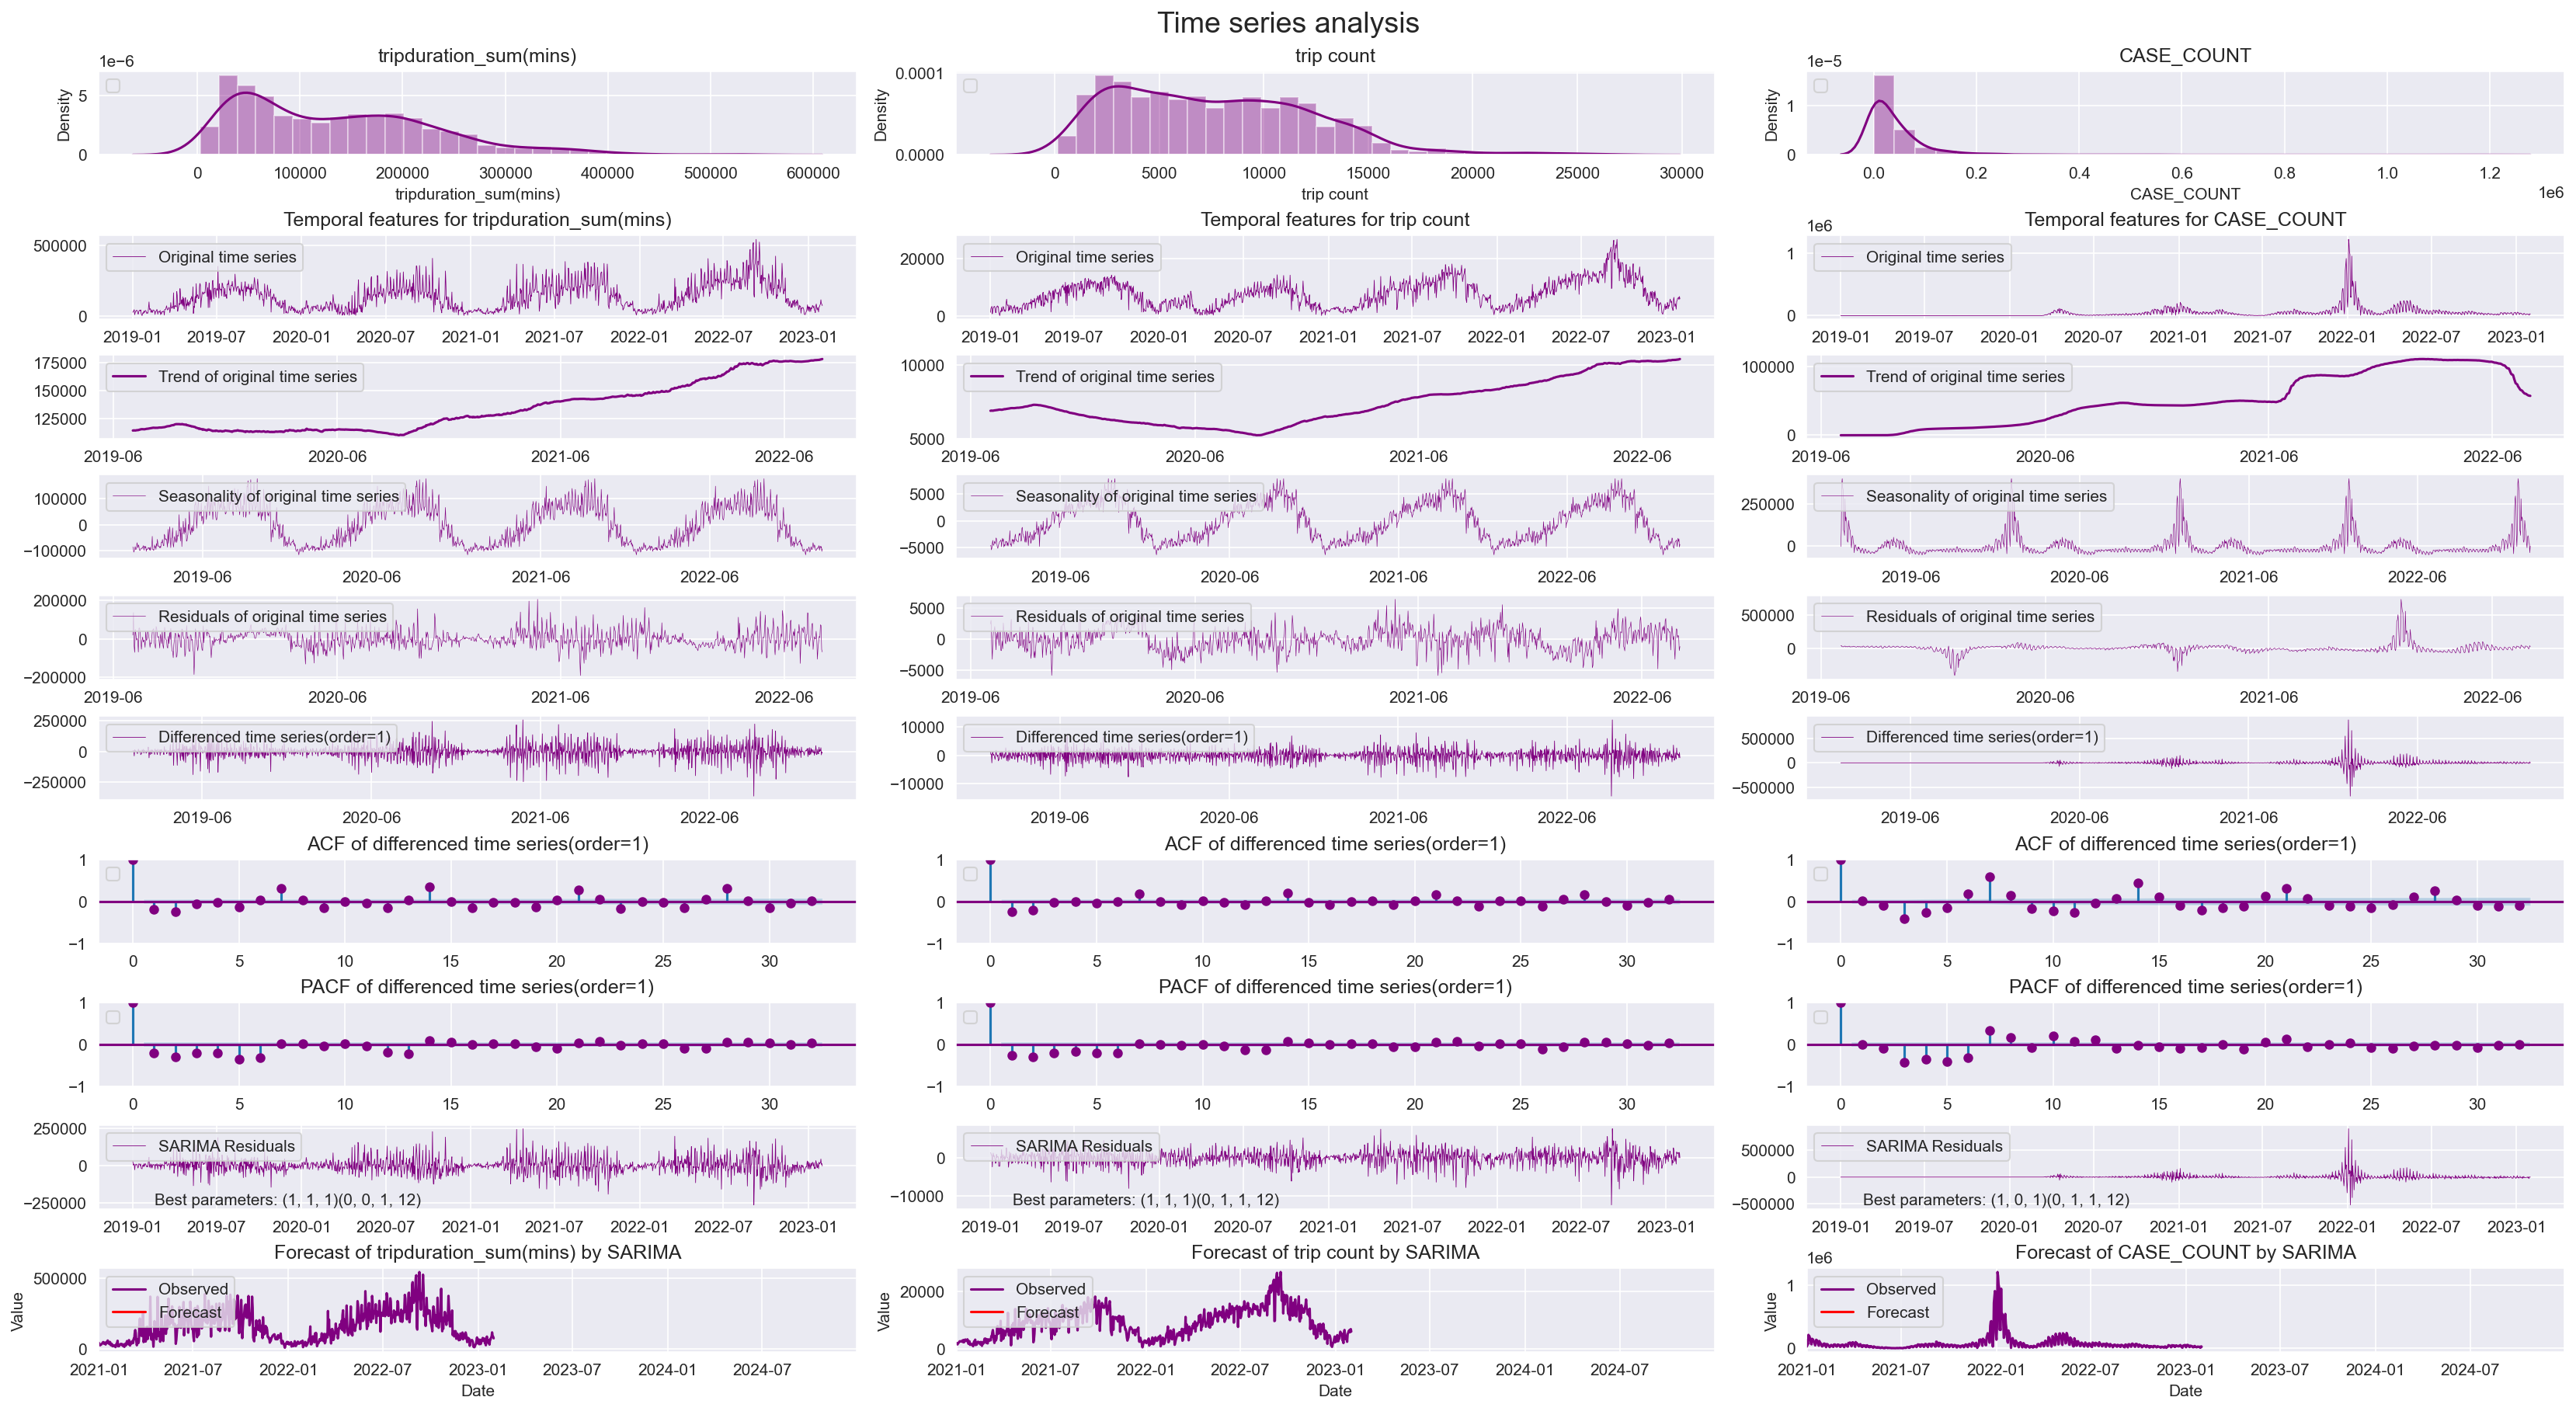

In [4]:
# visualizations
fig, ax = plt.subplots(10, len(types), figsize=(22, 12), dpi=150, constrained_layout=True)
for i in range(10):
    for j in range(3):
        decomposition = seasonal_decompose(df_temporal[types[j]], model='additive', period=365)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        if i == 0:
            sns.distplot(df_temporal[types[j]], hist=True, kde=True, bins=30, ax=ax[i, j], color='purple')
            ax[i, j].set_title(types[j])
            ax[i, j].legend(loc='upper left')
            # ax2 = ax[i, j].twinx()
            # stats.probplot(df_temporal[types[j]], plot=ax2)
            # ax2.set_ylabel('Normal QQ plot')
        elif i == 1:
            ax[i, j].plot(df_temporal[types[j]], linewidth=0.4, label='Original time series', color='purple')
            ax[i, j].set_title('Temporal features for {}'.format(types[j]))
            ax[i, j].legend(loc='upper left')
        elif i == 2:
            ax[i, j].plot(trend, label='Trend of original time series', color='purple')
            ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
            ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax[i, j].legend(loc='upper left')
        elif i == 3:
            ax[i, j].plot(seasonal, label='Seasonality of original time series', linewidth=0.3, color='purple')
            ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
            ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax[i, j].legend(loc='upper left')
        elif i == 4:
            ax[i, j].plot(residual, label='Residuals of original time series', linewidth=0.3, color='purple')
            ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
            ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax[i, j].legend(loc='upper left')
        elif i == 5:
            ax[i, j].plot(globals()['diff_1_{}'.format(j + 1)], linewidth=0.4, label='Differenced time series(order=1)',
                          color='purple')
            ax[i, j].legend(loc='upper left')
            ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
            ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        elif i == 6:
            sm.graphics.tsa.plot_acf(globals()['diff_1_{}'.format(j + 1)], ax=ax[i, j], color='purple')
            ax[i, j].set_title('ACF of differenced time series(order=1)')
            # ax[i, j].set_label('ACF of differenced time series(order=1) for {}'.format(types[j]))
            ax[i, j].legend(loc='upper left')
        elif i == 7:
            sm.graphics.tsa.plot_pacf(globals()['diff_1_{}'.format(j + 1)], ax=ax[i, j], color='purple')
            ax[i, j].set_title('PACF of differenced time series(order=1)')
            # ax[i, j].set_label('PACF of differenced time series(order=1) for {}'.format(types[j]))
            ax[i, j].legend(loc='upper left')
        elif i == 8:
            ax[i, j].plot(globals()['residuals_{}'.format(j + 1)], linewidth=0.4, label='SARIMA Residuals',
                          color='purple')
            ax[i, j].legend(loc='upper left')
            ax[i, j].text(0.25, 0.1, 'Best parameters: {}{}'.format(globals()['best_params_{}'.format(j + 1)],
                                                                    globals()['best_params_seasonal_{}'.format(j + 1)]),
                          horizontalalignment='center', verticalalignment='center', transform=ax[i, j].transAxes)
        elif i == 9:

            ax[i, j].plot(df_temporal[types[j]], label='Observed', color='purple')
            ax[i, j].set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2022-12-31'))
            ax[i, j].plot(globals()['forecast_{}'.format(j + 1)], label='Forecast', color='red')
            ax[i, j].set_xlim(pd.Timestamp('2022-12-31'), None)
            ax[i, j].set_title('Forecast of {} by SARIMA'.format(types[j]))
            ax[i, j].legend(loc='upper left')
            ax[i, j].set_xlabel('Date')
            ax[i, j].set_ylabel('Value')

        elif i == 10:
            sm.graphics.tsa.plot_acf(globals()['residuals_{}'.format(j + 1)], ax=ax[i, j], color='purple')
            ax[i, j].set_title('ACF of SARIMA residuals')
            # ax[i, j].set_label('ACF of residuals for {}'.format(types[j]))
            ax[i, j].legend(loc='upper left')

        elif i == 11:
            sm.graphics.tsa.plot_pacf(globals()['residuals_{}'.format(j + 1)], ax=ax[i, j], color='purple')
            ax[i, j].set_title('PACF of SARIMA residuals')
            # ax[i, j].set_label('PACF of residuals for {}'.format(types[j]))
            ax[i, j].legend(loc='upper left')
        else:
            continue

fig.suptitle('Time series analysis', fontsize=18)
plt.show()
fig.savefig('output/Time series analysis.png', dpi=300, bbox_inches='tight')

# restore the stdout
sys.stdout.close()
sys.stdout = sys.__stdout__